In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform, cdist
#import scipy

#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances

from lenskit.datasets import ML100K, MovieLens
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als
from lenskit import topn
from lenskit.metrics.predict import rmse, mae


In [2]:
def latent_factors_diversification(user_features, item_features, n_recs=10, top_n_limit=None):


    hat_ratings = np.dot(user_features, item_features.T) 

    if top_n_limit:
        #if constraining by top n, only retain the top n ratings within each user
        ind=np.argpartition(hat_ratings,-top_n_limit)[:,-top_n_limit:]
        n_ratings = np.take(hat_ratings, ind)
    else:
        #if not constraining by top n, retail all item indices for all users. 
        #If this is the case, in all_user_recs, recs_idxs should match original_recs_idxs
        ind=np.tile(np.arange(0,len(item_features)),(len(user_features),1))
        n_ratings = hat_ratings



    all_user_recs = dict()
    
    max_idx = np.argmax(n_ratings, axis=1)
    top_items=item_features[max_idx]
    
    all_recs = np.empty([user_features.shape[0],item_features.shape[1], n_recs])
    #all_recs = None
    

    for idx, user in enumerate(user_features):

        user_item_feats = item_features[ind[idx]]
        user_max_idx = np.argmax(n_ratings[idx])

        #get the top rec and add that as the first item for each user
        user_max = max_idx[idx]
        recs_features = top_items[idx]
        recs_idxs = [max_idx[idx]]
        recs_preds = [n_ratings[idx][user_max]]
        orig_recs_idxs = [ind[idx, user_max]]



        for rec in range(1,n_recs):
            if rec == 1:
                #for the second item, just use the first item values
                centroid = recs_features
            else:
                centroid = np.nanmean(recs_features, axis=0)

            centroid = centroid.reshape(1, -1)

            #set all the previously chosen item features to the centroid, so they will not be selected again
            #don't want to just remove rows because it will throw of the indexing
            user_item_feats[recs_idxs]=centroid

            d = pairwise_distances(X=centroid, Y=user_item_feats, metric='cityblock',force_all_finite='allow_nan' )
            most_distant = np.argmax(d)

            recs_idxs.append(most_distant)
            #get the item index from the original array of indices, not the constrained array
            orig_recs_idxs.append(ind[idx, most_distant])
            recs_preds.append(n_ratings[idx][most_distant])

            recs_features = np.vstack((recs_features, user_item_feats[most_distant]))

        all_recs[idx, :, :]=recs_features
            
        all_user_recs[idx]={'user_feats': user,
                        'original_recs_idx':orig_recs_idxs,
                        'recs_idx':recs_idxs,
                        'recs_features':recs_features,
                        'recs_preds':recs_preds}

        
    return all_recs, all_user_recs

In [3]:
def plot_real_hat_features(features_df, features_hat_df, feature_type):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}

    plt.rc('font', **font)

    n_features = list(range(0,10))
    fig, axs = plt.subplots(math.ceil(len(n_features)/3), 3, figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    fig.suptitle('Actual vs. Hat Representation for {} Factors'.format(feature_type), size=20)

    for idx, n_feature in enumerate(n_features):
        r=idx //3
        c=idx % 3

        hat = features_df[n_feature].tolist()
        actual = features_hat_df[n_feature].tolist()
        axs[r, c].set_title('Factor {}'.format(n_feature))

        axs[r,c].plot(hat, actual, 'o', color='blue');

    for ax in axs.flat:
        ax.set(xlabel='hat representation', ylabel='actual representation')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    fig.delaxes(axs[3][1])
    fig.delaxes(axs[3][2])

In [4]:
mlsmall = MovieLens('data/ml-latest-small')
#ml100k = ML100K('ml-100k')

In [5]:
ratings = mlsmall.ratings

In [6]:
ratings.head()

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
algo_als = als.BiasedMF(10, iterations=1000,reg=0.0001, bias=False, rng_spec=1)

algo_als.fit(ratings)
preds_als = batch.predict(algo_als, ratings)


#print("RMSE for ALS: {}".format(rmse(preds_als['prediction'], preds_als['rating'])))

algo_als_hat = als.BiasedMF(10, iterations=3,reg=0.0001, bias=False, rng_spec=1)

algo_als_hat.fit(ratings)
preds_als_hat = batch.predict(algo_als_hat, ratings)


print("RMSE for ALS: {}".format(rmse(preds_als['prediction'], preds_als['rating'])))
print("RMSE for ALS hat: {}".format(rmse(preds_als_hat['prediction'], preds_als_hat['rating'])))

print("MAE for ALS: {}".format(mae(preds_als['prediction'], preds_als['rating'])))
print("MAE for ALS hat: {}".format(mae(preds_als_hat['prediction'], preds_als_hat['rating'])))

RMSE for ALS: 0.4702929411448972
RMSE for ALS hat: 0.666539206060402
MAE for ALS: 0.3068730103459375
MAE for ALS hat: 0.4762743178903696


In [8]:
#Create the cartesian product of all possible users and movies
unique_movies = list(pd.unique(ratings['item'].dropna()))
unique_users = list(pd.unique(ratings['user'].dropna()))
all_index = pd.MultiIndex.from_product([unique_users, unique_movies], 
                                                    names = ["user","item"])
all_users_items = pd.DataFrame(index=all_index).reset_index()

#add in ratings, where ratings exist
all_users_items = pd.merge(all_users_items, ratings, on=['user', 'item'], how='left')

print("Number of users is {}. Number of items is {}.".format(len(unique_users), len(unique_movies)))
print("Length of all users and items is {}.".format(len(all_users_items)))
#all_users_items.sort_values(['user', 'item']).head(20)

Length of all users and items is 5931640
Number of users is 610. Number of items is 9724
Length of all users and items is 5931640


In [9]:
#make predictions for all user-item combinations 
all_preds = batch.predict(algo_als, all_users_items)
#all_preds.sort_values(['user', 'item']).head(12)
#all_preds.sort_values(['prediction'], ascending=False).head(20)

In [10]:
print("Summary statistics for 'actual' data...")
print("min")
print(preds_als.min())
print("\n")
print("max")
print(preds_als.max())
print("\n")
print("mean")
print(preds_als.mean())
print("\n")

print("Summary statistics for 'hat' data...")
print("min")
print(preds_als_hat.min())
print("\n")
print("max")
print(preds_als_hat.max())
print("\n")
print("mean")
print(preds_als_hat.mean())

Summary statistics for 'actual' data...
min
user          1.000000e+00
item          1.000000e+00
rating        5.000000e-01
timestamp     8.281246e+08
prediction   -5.885683e-01
dtype: float64


max
user          6.100000e+02
item          1.936090e+05
rating        5.000000e+00
timestamp     1.537799e+09
prediction    6.482499e+00
dtype: float64


mean
user          3.261276e+02
item          1.943530e+04
rating        3.501557e+00
timestamp     1.205946e+09
prediction    3.501593e+00
dtype: float64


Summary statistics for 'hat' data...
min
user          1.000000e+00
item          1.000000e+00
rating        5.000000e-01
timestamp     8.281246e+08
prediction   -6.050154e-01
dtype: float64


max
user          6.100000e+02
item          1.936090e+05
rating        5.000000e+00
timestamp     1.537799e+09
prediction    7.927820e+00
dtype: float64


mean
user          3.261276e+02
item          1.943530e+04
rating        3.501557e+00
timestamp     1.205946e+09
prediction    3.501120e+00
dt

## Plot Hat Item Features vs. Item Features

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


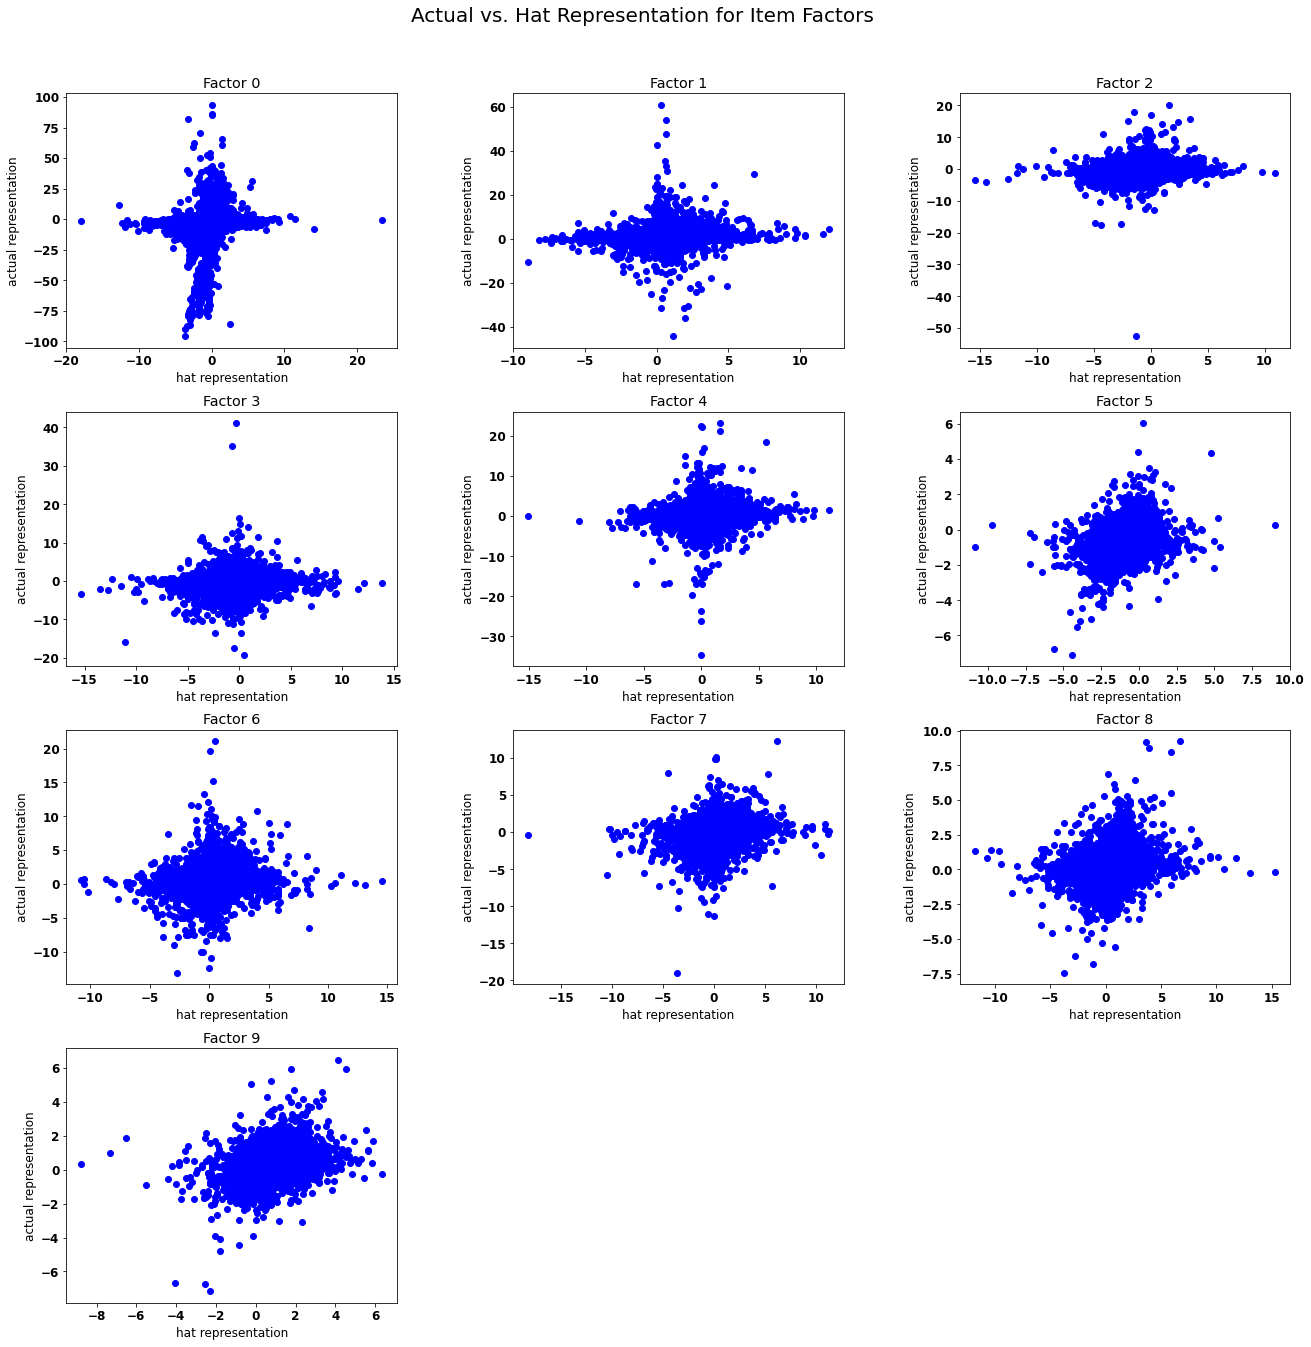

In [11]:
item_features_df=pd.DataFrame(algo_als.item_features_)
item_features_hat_df=pd.DataFrame(algo_als_hat.item_features_)
plot_real_hat_features(item_features_df, item_features_hat_df, "Item")

## Plot Hat User Features vs. User Features

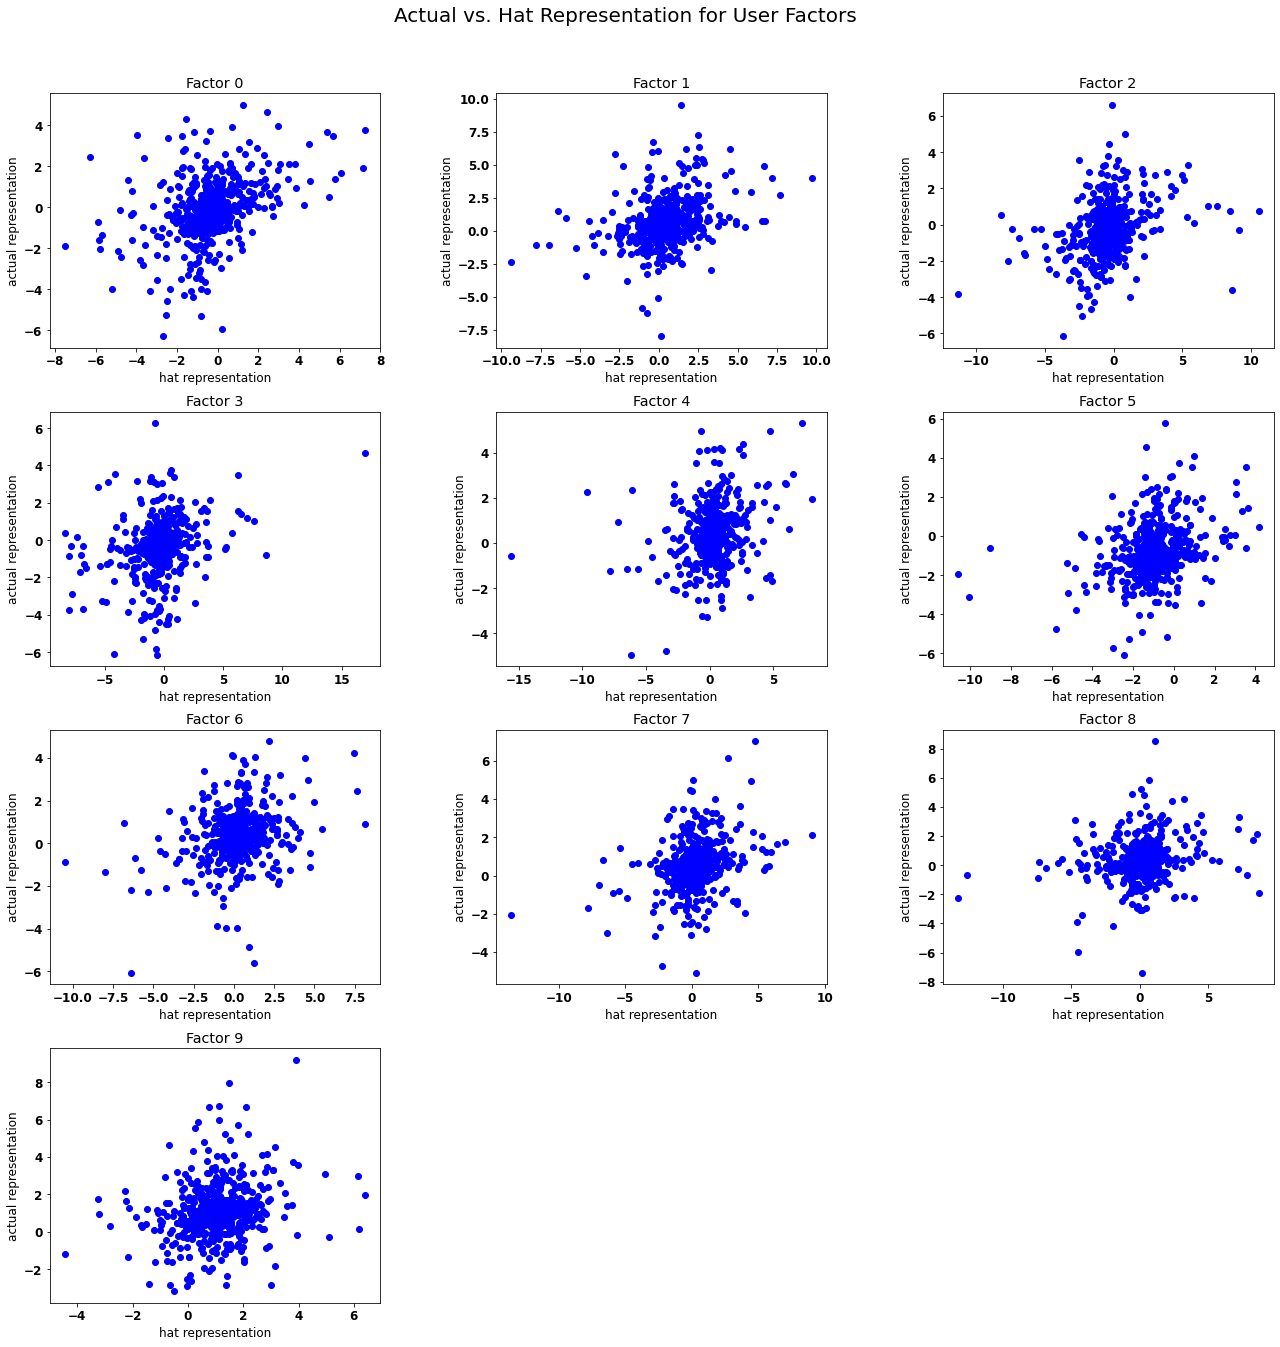

In [12]:
user_features_df=pd.DataFrame(algo_als.user_features_)
user_features_hat_df=pd.DataFrame(algo_als_hat.user_features_)
plot_real_hat_features(user_features_df, user_features_hat_df, "User")

In [13]:
#package everything up all nice and neat since eventually we will write this out as a json to import into t-recs
actual_items = {i:v for i,v in zip(algo_als.item_index_, algo_als.item_features_)}
actual_users = {u:v for u,v in zip(algo_als.user_index_, algo_als.user_features_)}

hat_items = {i:v for i,v in zip(algo_als_hat.item_index_, algo_als_hat.item_features_)}
hat_users = {u:v for u,v in zip(algo_als_hat.user_index_, algo_als_hat.user_features_)}

#TODO: set up json write out

## Generate recommendations for users using latent factors diversification

In [14]:
all_recs, ml_diverse_recs = latent_factors_diversification(user_features=algo_als.user_features_, 
                                                 item_features=algo_als.item_features_,
                                                 n_recs=10,top_n_limit=None)

In [15]:
def average_feature_score_range(recs):
    
    if len(recs.shape) == 3:
        #recs are aggregated across users
        
        return [sum(user.max(axis=0)-user.min(axis=0))/user.shape[1] for user in recs]
    else:
        #recs contains only a single user's recommendations
        return sum(recs.max(axis=0)-recs.min(axis=0))/recs.shape[1]
    

In [16]:
afsr = average_feature_score_range(all_recs)